<a href="https://colab.research.google.com/github/wenjunsun/personal-machine-learning-projects/blob/master/deep-learning/autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

in a previous notebook we manually wrote our own gradient descent algorithm, with the simplest case when model is linear and cost is MSE. What if we have a billion parameters with complex networks? We could theoretically do the same calculus chain rule and write our update rule again, but it will be slow and error prone.

Now that we know what is going on under the hood, we can use Pytorch's autograd function to automatically calculate gradient on the go when we are calculating the loss. We do this by setting the parameter tensor to have`require_grad` to be true. This basically says any tensor that is calculated from this tensor Pytorch will keep an eye on them and when we calculated everything, the gradient will be available ay any intermediate tensor and the base tensor for doing gradient descent.

Let's do the same thing we did before, but now with `autograd` functionality.

# 1. create synthetic data.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
tensor_celsius = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
tensor_fahrenheit = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

Text(0, 0.5, 'fahrenheit')

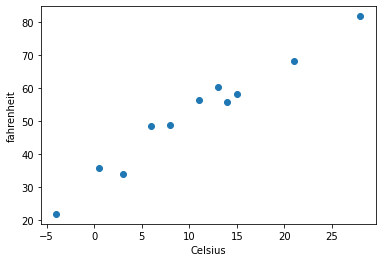

In [5]:
plt.scatter(tensor_celsius, tensor_fahrenheit)
plt.xlabel("Celsius")
plt.ylabel('fahrenheit')

# 2. define model + loss

In [6]:
def model(input_tensor, w, b):
  return input_tensor * w + b

In [7]:
# expects two tesnors, return mean square error.
def loss(predicted, expected):
  square_diffs = (predicted - expected)**2
  return square_diffs.mean()

# 3. training with autograd

In [8]:
# params = [w, b]
# requires_grad means we want pytorch to help us calculate
# gradient on this tensor later.
params = torch.tensor([1.0, 1.0], requires_grad = True)

In [9]:
# gradient calculation in action
y_pred = model(tensor_celsius, *params)
curr_loss = loss(y_pred, tensor_fahrenheit)
curr_loss.backward()

In [10]:
# WOA LA, this is the gradient!
params.grad

tensor([-968.5273,  -80.6000])

In [11]:
# zeroing out gradient (in place)
params.grad.zero_()

tensor([0., 0.])

In [23]:
def training_loop(num_epochs, learning_rate, params, x, y):
  # zeroing out the gradient on this tensor!!!! very important
  # because by default pytorch accumulate gradient, not set gradient
  for curr_epoch in range(1, num_epochs + 1):
    if params.grad is not None:
      params.grad.zero_()
    y_pred = model(x, *params)
    curr_loss = loss(y_pred, y)
    curr_loss.backward()
    # with enters a new context environment when
    # torch doesn't keep gradients of things, and so
    # woudln't construct a new graph structure when we
    # do calculatoin on the parameters.
    with torch.no_grad():
      params -= learning_rate * params.grad
    if curr_epoch % 1000 == 0:
      print(f'at epoch {curr_epoch} in the training, loss is {curr_loss}, and gradient is {params.grad}, and parameters is {params}')
  return params

In [24]:
final_params = training_loop(6000, 1e-3, torch.tensor([1., 1.], requires_grad=True), tensor_celsius, tensor_fahrenheit)

at epoch 1000 in the training, loss is 90.67216491699219, and gradient is tensor([  0.6461, -11.5051]), and parameters is tensor([ 2.5789, 18.9740], requires_grad=True)
at epoch 2000 in the training, loss is 25.434995651245117, and gradient is tensor([ 0.2843, -5.0619]), and parameters is tensor([ 2.1384, 26.8183], requires_grad=True)
at epoch 3000 in the training, loss is 12.806656837463379, and gradient is tensor([ 0.1251, -2.2271]), and parameters is tensor([ 1.9445, 30.2697], requires_grad=True)
at epoch 4000 in the training, loss is 10.36217975616455, and gradient is tensor([ 0.0550, -0.9799]), and parameters is tensor([ 1.8593, 31.7881], requires_grad=True)
at epoch 5000 in the training, loss is 9.888985633850098, and gradient is tensor([ 0.0241, -0.4311]), and parameters is tensor([ 1.8218, 32.4562], requires_grad=True)
at epoch 6000 in the training, loss is 9.797386169433594, and gradient is tensor([ 0.0107, -0.1897]), and parameters is tensor([ 1.8052, 32.7501], requires_grad=

In [25]:
final_params

tensor([ 1.8052, 32.7501], requires_grad=True)

As we can see, this is the correct `w` and `b` we have calculated before. This makes us more confident, as what we implemented matches with what pytorch autograd is doing

# 4. using `Pytorch` `optim` package

We can accomplish the same thing in the above code using pytorch's optimization package. This optimization package contains a lot of more advanced optimizers like Adam. what we implemented above is vanilla SGD with full dataset.

In [21]:
import torch.optim as optim

In [22]:
# dir method gives all the attributes/functions of an object
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_multi_tensor',
 'functional',
 'lr_scheduler',
 'swa_utils']

optimizers have two main methods: `zero_grad()` and `step()`. `zero_grad()` zeros out the gradient accumulated at the last step on the parameters, as expected, `step()` update the parameters the optimizers own in the direction of the graident, with some added abilities if optimizers is more complicated. For example, `Adam` optimizer will adaptively set the learning rate. Also `Adam` is insensitive to the scale of parameters

In [42]:
def training_loop(num_epochs, optimizer, params, x, y):
  for curr_epoch in range(1, num_epochs + 1):
    # zero out gradient accumulated in previous step as always!
    # this statement can be anywhere before .backward().
    optimizer.zero_grad()

    y_pred = model(x, *params)
    curr_loss = loss(y_pred, y)
    curr_loss.backward()

    optimizer.step() # update parametes this optimizer owns via GD

    if curr_epoch % 1000 == 0:
      print(f'at epoch {curr_epoch} in the training, loss is {curr_loss}, and gradient is {params.grad}, and parameters is {params}')
  return params

In [43]:
params = torch.tensor([1., 1.], requires_grad=True)
# constructor of optimizer takes in a list of list of parameters.
SGD_optimizer = optim.SGD([params], lr = 1e-03)

In [44]:
training_loop(6000, SGD_optimizer, params, tensor_celsius, tensor_fahrenheit)

at epoch 1000 in the training, loss is 90.67216491699219, and gradient is tensor([  0.6461, -11.5051]), and parameters is tensor([ 2.5789, 18.9740], requires_grad=True)
at epoch 2000 in the training, loss is 25.434995651245117, and gradient is tensor([ 0.2843, -5.0619]), and parameters is tensor([ 2.1384, 26.8183], requires_grad=True)
at epoch 3000 in the training, loss is 12.806656837463379, and gradient is tensor([ 0.1251, -2.2271]), and parameters is tensor([ 1.9445, 30.2697], requires_grad=True)
at epoch 4000 in the training, loss is 10.36217975616455, and gradient is tensor([ 0.0550, -0.9799]), and parameters is tensor([ 1.8593, 31.7881], requires_grad=True)
at epoch 5000 in the training, loss is 9.888985633850098, and gradient is tensor([ 0.0241, -0.4311]), and parameters is tensor([ 1.8218, 32.4562], requires_grad=True)
at epoch 6000 in the training, loss is 9.797386169433594, and gradient is tensor([ 0.0107, -0.1897]), and parameters is tensor([ 1.8052, 32.7501], requires_grad=

tensor([ 1.8052, 32.7501], requires_grad=True)

this result is exactly like before, but now we are using optimizer's SGD update instead of our own!

Let's try Adam, which is not sensitive to scale and sets adaptive learning rate

In [51]:
params = torch.tensor([1., 1.], requires_grad=True)
Adam_optimizer = optim.Adam([params])

In [52]:
training_loop(30000, Adam_optimizer, params, tensor_celsius, tensor_fahrenheit)

at epoch 1000 in the training, loss is 903.4595947265625, and gradient is tensor([-610.3125,  -59.7573]), and parameters is tensor([1.9042, 1.9368], requires_grad=True)
at epoch 2000 in the training, loss is 529.435546875, and gradient is tensor([-328.2633,  -43.2724]), and parameters is tensor([2.6102, 2.7633], requires_grad=True)
at epoch 3000 in the training, loss is 389.9152526855469, and gradient is tensor([-130.3012,  -31.5630]), and parameters is tensor([3.0962, 3.5124], requires_grad=True)
at epoch 4000 in the training, loss is 350.7929382324219, and gradient is tensor([-25.8822, -25.1154]), and parameters is tensor([3.3340, 4.2371], requires_grad=True)
at epoch 5000 in the training, loss is 331.8125915527344, and gradient is tensor([  3.4438, -22.8338]), and parameters is tensor([3.3687, 5.0126], requires_grad=True)
at epoch 6000 in the training, loss is 312.2503967285156, and gradient is tensor([  4.4817, -22.0649]), and parameters is tensor([3.3230, 5.8760], requires_grad=Tr

tensor([ 2.0618, 28.1719], requires_grad=True)

As we can see, Adam takes a lot of epoches to get to the optimum, but we don't need to set our own learning rate, which is cool!

# Conclusion

As we can see there are two things we need to keep in mind when we use `autograd` in `pytorch`:
- remember to zero out gradient before next `.backward()` because `.backward()` **accumulates** the gradient on tensors, and so will add the current gradient to the gradient before it.
- do `with torch.no_grad()` when update `parameters` as to not create a new computational graph out of it when we do calculation on a tensor that `requires_grad`. which it normally will do.
- `optim` package abstracts away the optimization step